In [8]:
# using GuSTO
include("../src/GuSTO.jl")
using AstrobeeRobot

In [2]:
robot = Freeflyer()
model = FreeflyerSE2()

FreeflyerSE2(6, 3, 0.05, Any[], Any[], Any[])

In [ ]:
env = Table(:stanford);
centers = Vector()
push!(centers, [0.460; 0.315; 0.0])
push!(centers, [0.201; 1.085; 0.0])
push!(centers, [0.540; 2.020; 0.0])
push!(centers, [1.374; 0.196; 0.0])
push!(centers, [1.063; 1.354; 0.0])
push!(centers, [1.365; 2.322; 0.0])
push!(centers, [2.221; 0.548; 0.0])
push!(centers, [2.077; 1.443; 0.0])
push!(centers, [3.098; 1.186; 0.0])
push!(centers, [2.837; 2.064; 0.0])

widths = [0.27; 0.27; 0.127]
inflation = 0.05*ones(3)

for idx in 1:length(centers)
    push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
end

N = 200
tf_guess = 200.
x_init = [0.2; 2.4; 0; 0; 0; 0]
goal_set = GoalSet()
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))

PD = ProblemDefinition(robot, model, env, x_init, goal_set)

TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
TOSgusto = TrajectoryOptimizationSolution(TOP)

SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0);
# SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0);
# SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Mosek");

In [4]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

(TOSgusto.SCPS).converged = true
(TOSgusto.SCPS).iterations = 28
(TOSgusto.SCPS).total_time = 23.845841663999998
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true, false, false, false, true, true, true, false, false, false, false, false, false, false, true, true, true, true, true, true, true, true, true]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL, OPTIMAL]
(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK, :OK, :OK, :OK, :InaccurateModel, :InaccurateModel, :InaccurateModel, :OK, :OK, :OK, :InaccurateModel, :InaccurateModel, :InaccurateModel, :InaccurateModel, :InaccurateModel, :InaccurateModel, :InaccurateModel, :ViolatesConstraints, :OK, :ViolatesConstraints, :OK, :OK, :OK, :OK, :OK

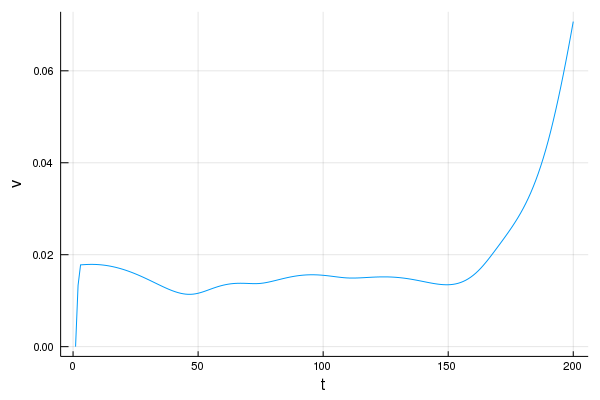

In [5]:
using Plots
gr(fmt=:png)
plot()
plot!([collect(1:N)],[sqrt.(TOSgusto.SCPS.traj.X[4,:].^2 + TOSgusto.SCPS.traj.X[5,:].^2)],
    xlabel = "t",
    ylabel = "v",
    legend = :none)
plot!()

### Output trajectory file

In [6]:
using HDF5

h5open("predefined_trajectory_example.h5", "w") do file
    traj = g_create(file, "traj")
    traj["x_traj"] = TOSgusto.traj.X
    traj["u_traj"] = TOSgusto.traj.U
    traj["t_traj"] = collect(0:TOSgusto.traj.dt:TOSgusto.traj.Tf)
    
    # Indexing verification information (zero-indexed)
    ind_x = g_create(file, "ind_x")
    ind_x["x"] = 0
    ind_x["y"] = 1
    ind_x["theta"] = 2
    ind_x["vx"] = 3
    ind_x["vy"] = 4
    ind_x["omega"] = 5
    ind_u = g_create(file, "ind_u")
    ind_u["Fx"] = 0
    ind_u["Fy"] = 1
    ind_u["M"] = 2
end
;

### Animate free-flyer trajectory

In [ ]:
vis = Visualizer()
delete!(vis)

vis[:goal]
setobject!(vis[:goal][:goal], 
    Object(HyperSphere(Point3(x_goal[1:2]..., robot.r), 0.1),
        MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

vis[:table]
table_dim = env.worldAABBmax-env.worldAABBmin
setobject!(vis[:table][:table], 
        Object(HyperRectangle(env.worldAABBmin..., table_dim...),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

vis[:obstacles]
for (idx,obs) in enumerate(env.obstacle_set)
    setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
        Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,0.3))))
end

vis[:robot]

setobject!(vis[:robot][:base],
    Object(Cylinder(Point3f0(0,0,0.),Point3f0(0.,0.,0.5),Float32(robot.r)),MeshBasicMaterial(color=RGBA(0,0.,1.,0.7))))

up = [0;0;1.]
q0 = vec2quat(up,x_init[3])
Qs = Vector{Vector{Float64}}()

speed_factor = 10

for k in 1:speed_factor:N
    q = [quat_inv(quat_multiply(mrp2quat([0.; 0.; tan(TOSgusto.SCPS.traj.X[3,k]/4)]), q0)); [TOSgusto.SCPS.traj.X[1:2,k]; robot.r]]
    push!(Qs,q)
end

anim = MeshCat.Animation()
for k in 1:N
    atframe(anim, vis, 5*k) do frame
        settransform!(frame[:robot], Translation(TOSgusto.traj.X[1,k], 
            TOSgusto.traj.X[2,k], TOSgusto.traj.X[3,k]))
    end
end
setanimation!(vis, anim)
    
# plot_in_cell = true
plot_in_cell = false
plot_in_cell ? IJuliaCell(vis) : open(vis)